In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os

import numpy as np
import torch
from torch.nn.modules.loss import CrossEntropyLoss
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
import random

from handwriting_recognition.label_converter import LabelConverter
from handwriting_recognition.model.model import HandwritingRecognitionModel
from handwriting_recognition.modelling_utils import get_image_model
from handwriting_recognition.utils import TrainingConfig, get_dataset_folder_path
from handwriting_recognition.dataset import HandWritingDataset
from pathlib import Path
from handwriting_recognition.modelling_utils import get_device
from handwriting_recognition.eval import cer, wer

torch.backends.cudnn.benchmark = True

/home/faraz/.cache/pypoetry/virtualenvs/handwriting-recognition-05HTZ8rb-py3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [3]:
CONFIG_NAME = "resnet_config"
MODEL_DIR = Path(get_dataset_folder_path()).parent.joinpath("model_outputs", CONFIG_NAME)
config_path = Path(get_dataset_folder_path()).parent.joinpath("handwriting_recognition", "configs", CONFIG_NAME).with_suffix(".json")
config = TrainingConfig.from_path(config_path=config_path)

In [4]:
all_epochs = [x for x in sorted(os.listdir(MODEL_DIR)) if x.isdigit()]

In [5]:
all_epochs

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [6]:
BATCH_SIZE = 192

In [7]:
from handwriting_recognition.train import _evaluate

data_train = HandWritingDataset(
data_path=get_dataset_folder_path() / "pre_processed" / "train.csv",
img_size=config.feature_extractor_config.input_size,
)

data_val = HandWritingDataset(
    data_path=get_dataset_folder_path() / "pre_processed" / "validation.csv",
    img_size=config.feature_extractor_config.input_size,
)

train_loader = DataLoader(
    data_train,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)

val_loader = DataLoader(
    data_val,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=False,
    drop_last=False,
)
loss_function = CrossEntropyLoss(ignore_index=0).to(get_device())

val_metrics = []
train_metrics = []

for epoch in all_epochs:
    model_file = os.path.join(MODEL_DIR, epoch)
    saved_model = torch.load(model_file)
    config = TrainingConfig(**saved_model['config'])

    image_model = get_image_model(model_name=config.feature_extractor_config.model_name)
    model = HandwritingRecognitionModel(image_feature_extractor=image_model, training_config=config)
    model.load_state_dict(saved_model["state"])
    converter = LabelConverter(character_set=saved_model['character_set'], max_text_length=saved_model['max_text_length'])
    
    model = model.to(get_device())
    model = model.eval()

    validation_loss, val_character_error_rate, val_word_error_rate, all_val_preds, all_val_ground_truths = _evaluate(
        epoch=saved_model['epoch'],
        model=model,
        data_loader=val_loader,
        converter=converter,
        loss_function=loss_function,
        max_iter=250,
    )
    val_metrics.append({
        "loss": validation_loss.item(),
        "epoch": int(epoch),
        "cer": val_character_error_rate.item(),
        "wer": val_word_error_rate.item(),
        "preds": all_val_preds,
        "ground_truths": all_val_ground_truths
    })
    train_loss, train_character_error_rate, train_word_error_rate, all_train_preds, all_train_ground_truths = _evaluate(
        epoch=saved_model['epoch'],
        model=model,
        data_loader=train_loader,
        converter=converter,
        loss_function=loss_function,
        max_iter=250
    )
    train_metrics.append({
        "loss": train_loss.item(),
        "epoch": int(epoch),
        "cer": train_character_error_rate.item(),
        "wer": train_word_error_rate.item(),
        "preds": all_train_preds,
        "ground_truths": all_train_ground_truths
    })
    print(
        f"Validation Loss at epoch {epoch}: {validation_loss:.4f}, WER: {val_word_error_rate}, CER: {val_character_error_rate}. Best Loss so far:"
    )
    
    print(
        f"Training Loss at epoch {epoch}: {train_loss:.4f}, WER: {train_word_error_rate}, CER: {train_character_error_rate}. Best Loss so far:"
    )

Validating Epoch: 1: 100% 208/208 [00:43<00:00,  4.76it/s]


Outputting sample of validation outputs.
['ALICE', 'BENTELLER', 'CARILLIER', 'LISA', 'BOURET', 'MATHIS', 'MATHIS', 'BENTE   BARIER', 'MATHIS', 'LUCA']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 1:  15% 249/1661 [00:50<04:48,  4.89it/s]


Outputting sample of validation outputs.
['BENTELLER', 'LOUIS', 'LOUIS', 'BERRET', 'MATHIS', 'ALICE', 'MATHIS', 'BERRAUDE', 'ANTOINE', 'ALICE']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 1: 3.1855, WER: 1.0079501867294312, CER: 0.8393059968948364. Best Loss so far:
Training Loss at epoch 1: 3.1864, WER: 1.0059702396392822, CER: 0.8385910987854004. Best Loss so far:


Validating Epoch: 10: 100% 208/208 [00:41<00:00,  4.99it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMOHIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANZEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 10:  15% 249/1661 [00:50<04:46,  4.93it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'JLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 10: 0.3873, WER: 0.32397031784057617, CER: 0.08868791908025742. Best Loss so far:
Training Loss at epoch 10: 0.3710, WER: 0.31469282507896423, CER: 0.085292287170887. Best Loss so far:


Validating Epoch: 11: 100% 208/208 [00:42<00:00,  4.93it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 11:  15% 249/1661 [00:50<04:49,  4.88it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPANE', 'LUCIE', 'MASSIM', 'ASSRAQUI', 'TIAVIAN', 'MAEYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 11: 0.4366, WER: 0.3668103516101837, CER: 0.10340850055217743. Best Loss so far:
Training Loss at epoch 11: 0.4170, WER: 0.359270840883255, CER: 0.099811851978302. Best Loss so far:


Validating Epoch: 12: 100% 208/208 [00:42<00:00,  4.93it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUFP', 'PICHON', 'BANIEL', 'JEREMY', 'TEHNEICHE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 12:  15% 249/1661 [00:51<04:49,  4.87it/s]


Outputting sample of validation outputs.
['BAITHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHAE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 12: 0.4857, WER: 0.3973419666290283, CER: 0.11707707494497299. Best Loss so far:
Training Loss at epoch 12: 0.4710, WER: 0.3949730396270752, CER: 0.11340164393186569. Best Loss so far:


Validating Epoch: 13: 100% 208/208 [00:42<00:00,  4.88it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMOHIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 13:  15% 249/1661 [00:50<04:47,  4.90it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 13: 0.3587, WER: 0.304238498210907, CER: 0.08090683072805405. Best Loss so far:
Training Loss at epoch 13: 0.3441, WER: 0.2942347228527069, CER: 0.07663626968860626. Best Loss so far:


Validating Epoch: 14: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 14:  15% 249/1661 [00:50<04:48,  4.89it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHUE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'JUAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 14: 0.4366, WER: 0.35445401072502136, CER: 0.09980537742376328. Best Loss so far:
Training Loss at epoch 14: 0.4136, WER: 0.34438496828079224, CER: 0.09444606304168701. Best Loss so far:


Validating Epoch: 15: 100% 208/208 [00:42<00:00,  4.90it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 15:  15% 249/1661 [00:51<04:49,  4.88it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'GIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 15: 0.4344, WER: 0.3695162832736969, CER: 0.1009325310587883. Best Loss so far:
Training Loss at epoch 15: 0.4150, WER: 0.3575991690158844, CER: 0.09651849418878555. Best Loss so far:


Validating Epoch: 16: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 16:  15% 249/1661 [00:51<04:50,  4.87it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 16: 0.3599, WER: 0.2998563349246979, CER: 0.08049353957176208. Best Loss so far:
Training Loss at epoch 16: 0.3471, WER: 0.2905729413032532, CER: 0.07703698426485062. Best Loss so far:


Validating Epoch: 17: 100% 208/208 [00:42<00:00,  4.89it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'BANIEL', 'JEREMY', 'JEPNIMICHEL', 'JULIEN', 'NAGL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 17:  15% 249/1661 [00:50<04:49,  4.88it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'GUCIE', 'MASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 17: 0.4781, WER: 0.38694924116134644, CER: 0.10961534082889557. Best Loss so far:
Training Loss at epoch 17: 0.4603, WER: 0.3779577612876892, CER: 0.10603541880846024. Best Loss so far:


Validating Epoch: 18: 100% 208/208 [00:42<00:00,  4.89it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'TEHN MIENELE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 18:  15% 249/1661 [00:51<04:49,  4.88it/s]


Outputting sample of validation outputs.
['BALTHAITRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'JUCIE', 'NASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 18: 0.4079, WER: 0.3424569070339203, CER: 0.09559734910726547. Best Loss so far:
Training Loss at epoch 18: 0.3948, WER: 0.3366236090660095, CER: 0.09187586605548859. Best Loss so far:


Validating Epoch: 19: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 19:  15% 249/1661 [00:50<04:48,  4.90it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 19: 0.3408, WER: 0.28936782479286194, CER: 0.07641701400279999. Best Loss so far:
Training Loss at epoch 19: 0.3245, WER: 0.27932894229888916, CER: 0.07188720256090164. Best Loss so far:


Validating Epoch: 2: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BOLLE', 'LAURANDES', 'FERRANDER', 'RAUX', 'PICHOT', 'JADILE', 'JEANNE', 'FERNANDERE', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 2:  15% 249/1661 [00:50<04:45,  4.94it/s]


Outputting sample of validation outputs.
['BASTARDAN', 'SORIA', 'DENIS', 'CASSIE', 'THOMAS', 'CULIE', 'MAELYS', 'MOURAULT', 'TIMOTHA', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 2: 2.0120, WER: 0.8631705045700073, CER: 0.5623652338981628. Best Loss so far:
Training Loss at epoch 2: 2.0020, WER: 0.8599573969841003, CER: 0.5604778528213501. Best Loss so far:


Validating Epoch: 20: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 20:  15% 249/1661 [00:50<04:48,  4.90it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAUI', 'YLAVIAN', 'MACYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 20: 0.4706, WER: 0.362595796585083, CER: 0.10202210396528244. Best Loss so far:
Training Loss at epoch 20: 0.4544, WER: 0.35552945733070374, CER: 0.09899477660655975. Best Loss so far:


Validating Epoch: 21: 100% 208/208 [00:41<00:00,  4.97it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEYN MIEMEL', 'JULIEN', 'NAELL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 21:  15% 249/1661 [00:50<04:45,  4.95it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 21: 0.3779, WER: 0.31314656138420105, CER: 0.08307095617055893. Best Loss so far:
Training Loss at epoch 21: 0.3584, WER: 0.3040856420993805, CER: 0.07966039329767227. Best Loss so far:


Validating Epoch: 22: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUFP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 22:  15% 249/1661 [00:51<04:49,  4.88it/s]


Outputting sample of validation outputs.
['BALTHAJAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIN', 'ASSRAOUI', 'TLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 22: 0.3829, WER: 0.31877395510673523, CER: 0.08539288491010666. Best Loss so far:
Training Loss at epoch 22: 0.3695, WER: 0.3117474913597107, CER: 0.0820646733045578. Best Loss so far:


Validating Epoch: 23: 100% 208/208 [00:41<00:00,  4.98it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 23:  15% 249/1661 [00:50<04:47,  4.91it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'YLAVIAN', 'MACYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 23: 0.3867, WER: 0.3342432975769043, CER: 0.09056274592876434. Best Loss so far:
Training Loss at epoch 23: 0.3671, WER: 0.32591694593429565, CER: 0.08639737218618393. Best Loss so far:


Validating Epoch: 24: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEYN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 24:  15% 249/1661 [00:50<04:45,  4.94it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 24: 0.3470, WER: 0.2860153317451477, CER: 0.0760713592171669. Best Loss so far:
Training Loss at epoch 24: 0.3303, WER: 0.27731895446777344, CER: 0.0718715488910675. Best Loss so far:


Validating Epoch: 25: 100% 208/208 [00:41<00:00,  4.98it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 25:  15% 249/1661 [00:50<04:44,  4.96it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 25: 0.3623, WER: 0.3084530532360077, CER: 0.08176722377538681. Best Loss so far:
Training Loss at epoch 25: 0.3463, WER: 0.3010607063770294, CER: 0.07830799371004105. Best Loss so far:


Validating Epoch: 26: 100% 208/208 [00:41<00:00,  4.95it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 26:  15% 249/1661 [00:50<04:46,  4.93it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHUE', 'LUCIE', 'MASSIN', 'ASSRADUI', 'YLAVIAN', 'NAGUA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 26: 0.3888, WER: 0.33302202820777893, CER: 0.08984137326478958. Best Loss so far:
Training Loss at epoch 26: 0.3722, WER: 0.3216382563114166, CER: 0.08624085038900375. Best Loss so far:


Validating Epoch: 27: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEHN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 27:  15% 249/1661 [00:50<04:44,  4.96it/s]


Outputting sample of validation outputs.
['BALTHAIAR', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'NASSIN', 'ASSRAOUI', 'FLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 27: 0.3635, WER: 0.2954980731010437, CER: 0.07746151089668274. Best Loss so far:
Training Loss at epoch 27: 0.3466, WER: 0.28569722175598145, CER: 0.07339300215244293. Best Loss so far:


Validating Epoch: 28: 100% 208/208 [00:41<00:00,  4.97it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NALL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 28:  15% 249/1661 [00:50<04:44,  4.96it/s]


Outputting sample of validation outputs.
['BALTHAZER', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'YLAVIAN', 'MACYA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 28: 0.3608, WER: 0.3088841140270233, CER: 0.08145161718130112. Best Loss so far:
Training Loss at epoch 28: 0.3453, WER: 0.29885172843933105, CER: 0.07741577923297882. Best Loss so far:


Validating Epoch: 3: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BILLE', 'LAUMENTER', 'JEAN ABER', 'RUBA', 'PICHON', 'BANIEL', 'LERENN', 'JEAN MATHEAU', 'JULIEN', 'MAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 3:  15% 249/1661 [00:50<04:45,  4.94it/s]


Outputting sample of validation outputs.
['BALANNEAU', 'GINON', 'DENES', 'CALOSE', 'DAPHIE', 'LOCIE', 'MAEVON', 'ROGANDOT', 'DENTIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 3: 1.2638, WER: 0.7295258641242981, CER: 0.36517030000686646. Best Loss so far:
Training Loss at epoch 3: 1.2539, WER: 0.7241736054420471, CER: 0.3616962730884552. Best Loss so far:


Validating Epoch: 4: 100% 208/208 [00:41<00:00,  4.97it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DAMIEL', 'JEREMY', 'JEAN MALUEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 4:  15% 249/1661 [00:50<04:45,  4.95it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LOCIE', 'MASSIM', 'ASSAROUI', 'FLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 4: 0.7097, WER: 0.5177682042121887, CER: 0.19888561964035034. Best Loss so far:
Training Loss at epoch 4: 0.6918, WER: 0.5079504251480103, CER: 0.19343145191669464. Best Loss so far:


Validating Epoch: 5: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'SEAN   LIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 5:  15% 249/1661 [00:50<04:46,  4.93it/s]


Outputting sample of validation outputs.
['BALTHASAR', 'GIMON', 'BENES', 'LACOUE', 'DAPHNE', 'LUCIE', 'MASSIM', 'ASSAROUI', 'PLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 5: 0.6375, WER: 0.48781129717826843, CER: 0.1762261539697647. Best Loss so far:
Training Loss at epoch 5: 0.6179, WER: 0.4786961078643799, CER: 0.1711292862892151. Best Loss so far:


Validating Epoch: 6: 100% 208/208 [00:41<00:00,  4.97it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCCH', 'RUPA', 'PICHON', 'DANIEL', 'JERIAN', 'TEAN MIENEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 6:  15% 249/1661 [00:50<04:45,  4.94it/s]


Outputting sample of validation outputs.
['BALTHAIRA', 'SIMON', 'BENOS', 'LALOUE', 'DAPHNE', 'LOCIE', 'MASSIM', 'ASSRAOUI', 'VIANIAN', 'MAENA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 6: 0.6807, WER: 0.5284722447395325, CER: 0.18051308393478394. Best Loss so far:
Training Loss at epoch 6: 0.6648, WER: 0.5256224274635315, CER: 0.17705857753753662. Best Loss so far:


Validating Epoch: 7: 100% 208/208 [00:41<00:00,  4.96it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN    MILLEEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 7:  15% 249/1661 [00:50<04:45,  4.95it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'SIMON', 'BENES', 'LALOUC', 'DAPHNE', 'JUCIE', 'MASSIN', 'ASSRAOUI', 'YLANIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 7: 0.5251, WER: 0.3972940742969513, CER: 0.12508359551429749. Best Loss so far:
Training Loss at epoch 7: 0.5008, WER: 0.38450515270233154, CER: 0.12027949839830399. Best Loss so far:


Validating Epoch: 8: 100% 208/208 [00:41<00:00,  4.98it/s]


Outputting sample of validation outputs.
['BILEEL', 'LAUMONIER', 'JEAN ROCH', 'RUPA', 'PICHON', 'DANIEL', 'JEREMY', 'FERN MIENCE', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 8:  15% 249/1661 [00:50<04:45,  4.94it/s]


Outputting sample of validation outputs.
['BALTHAIRR', 'GIMON', 'BENES', 'LALOUE', 'DAPHNE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'YLAVIAN', 'MAEVA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 8: 0.5067, WER: 0.41580459475517273, CER: 0.12446366250514984. Best Loss so far:
Training Loss at epoch 8: 0.4880, WER: 0.40436625480651855, CER: 0.11994139850139618. Best Loss so far:


Validating Epoch: 9: 100% 208/208 [00:42<00:00,  4.92it/s]


Outputting sample of validation outputs.
['BILEL', 'LAUMONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']
['BILEL', 'LAUMIONIER', 'JEAN ROCH', 'RUPP', 'PICHON', 'DANIEL', 'JEREMY', 'JEAN MICHEL', 'JULIEN', 'NAEL']


Validating Epoch: 9:  15% 249/1661 [00:51<04:50,  4.86it/s]


Outputting sample of validation outputs.
['BALTVAIRR', 'SIMON', 'BENES', 'LALOUE', 'DARANE', 'LUCIE', 'MASSIN', 'ASSRAOUI', 'VIANIAN', 'MAEWA']
['BALTHAZAR', 'SIMON', 'BENES', 'LA LOVE', 'DAPHNE', 'LUCIE', 'NASSIM', 'ASSRAOUI', 'LAVIAN', 'MAEVA']
Validation Loss at epoch 9: 0.5225, WER: 0.4346024990081787, CER: 0.1290699541568756. Best Loss so far:
Training Loss at epoch 9: 0.5064, WER: 0.42737168073654175, CER: 0.12504108250141144. Best Loss so far:


In [8]:
import pickle

with open("train_metrics.pkl", 'wb') as f:
    pickle.dump(train_metrics, f)
    
with open("val_metrics.pkl", 'wb') as f:
    pickle.dump(val_metrics, f)

In [9]:
all_val_losses = [(x['loss'], x['epoch']) for x in val_metrics]
all_train_losses = [(x['loss'], x['epoch']) for x in train_metrics]

all_val_losses.sort(key=lambda x: x[1])
all_train_losses.sort(key=lambda x: x[1])

In [10]:
val_loss, val_epochs = zip(*all_val_losses)
train_loss, train_epochs = zip(*all_train_losses)

In [11]:
train_loss

(3.1864354610443115,
 2.001952648162842,
 1.2538769245147705,
 0.6917998790740967,
 0.6179044246673584,
 0.6647945046424866,
 0.5008330941200256,
 0.4879798889160156,
 0.5064135193824768,
 0.37103307247161865,
 0.41696953773498535,
 0.4710235297679901,
 0.3440960943698883,
 0.413607656955719,
 0.4149801433086395,
 0.34705957770347595,
 0.4603434205055237,
 0.39477068185806274,
 0.32447174191474915,
 0.45435890555381775,
 0.3583988845348358,
 0.36948925256729126,
 0.3670949935913086,
 0.3302939236164093,
 0.3463255763053894,
 0.37222743034362793,
 0.3466140031814575,
 0.34528201818466187)

In [12]:
all_val_cer = [(x['cer'], x['epoch']) for x in val_metrics]
all_train_cer = [(x['cer'], x['epoch']) for x in train_metrics]

all_val_cer.sort(key=lambda x: x[1])
all_train_cer.sort(key=lambda x: x[1])

In [13]:
val_cer, val_epochs = zip(*all_val_cer)
train_cer, train_epochs = zip(*all_train_cer)

In [14]:
import matplotlib.pyplot as plt

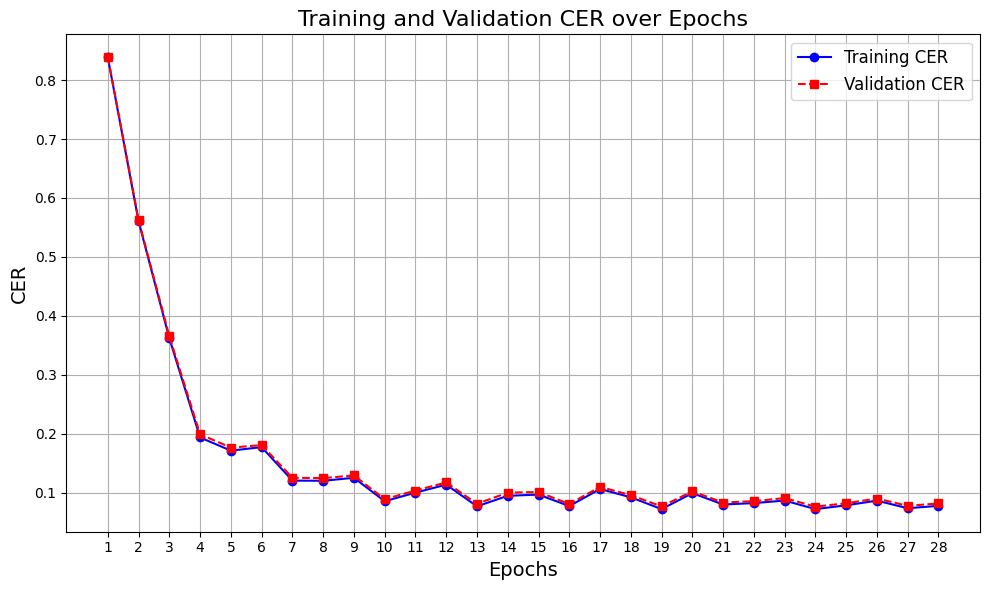

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_cer, marker='o', linestyle='-', color='b', label='Training CER')
plt.plot(val_epochs, val_cer, marker='s', linestyle='--', color='r', label='Validation CER')

plt.title('Training and Validation CER over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('CER', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, max(train_epochs) + 1)) 

plt.tight_layout()
plt.show()

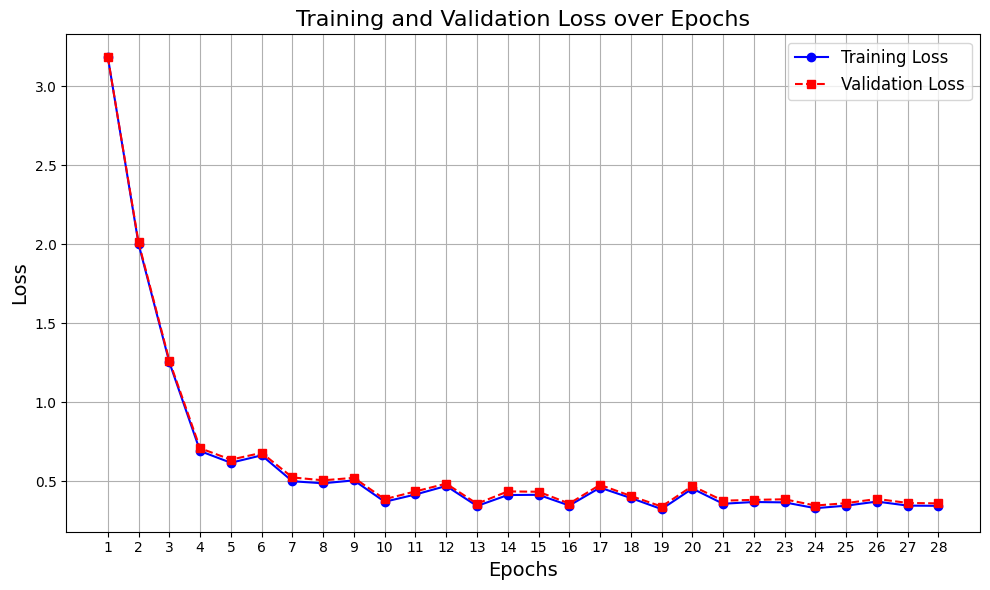

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(train_epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(val_epochs, val_loss, marker='s', linestyle='--', color='r', label='Validation Loss')

plt.title('Training and Validation Loss over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(1, max(train_epochs) + 1)) 

plt.tight_layout()
plt.show()